In [2]:
import numpy
import pandas as pd
import torch
import numpy as np
#from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import os,random
import torchvision.transforms as T
from torchvision.transforms.functional import crop
import csv
import cv2
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from torch.utils.tensorboard import SummaryWriter #tensorboard --logdir log --bind_all


In [3]:
import os

# 获取当前路径
current_directory = os.getcwd()
print("当前路径:", current_directory)

# 定义要变更的目标路径
target_directory = "/home/br-python/Documents/chen/20230925-test-CG/"

# 使用os.chdir()来变更路径
os.chdir(target_directory)

# 再次获取当前路径，此时它应该是目标路径
new_current_directory = os.getcwd()
print("变更后的路径:", new_current_directory)


当前路径: /home/br-python
变更后的路径: /home/br-python/Documents/chen/20230925-test-CG


In [4]:
def calculate_dense_optical_flow(reference_image, deformed_image):
    # 转换为灰度图像
    reference_gray = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)
    deformed_gray = cv2.cvtColor(deformed_image, cv2.COLOR_BGR2GRAY)

    # 使用Farneback密集光流算法计算光流
    flow = cv2.calcOpticalFlowFarneback(reference_gray, deformed_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    return flow

def dic_func(rowpic,defpic):
    # 读取参考图像和变形图像
    reference_image = cv2.imread(rowpic)
    deformed_image = cv2.imread(defpic)
    new_height, new_width = (1600, 1600)  # 设置新的尺寸

    reference_image = cv2.resize(reference_image, (new_width, new_height))
    deformed_image = cv2.resize(deformed_image, (new_width, new_height))

    # 使用SIFT特征检测器
    sift = cv2.SIFT_create()

    # 查找关键点和描述符
    keypoints1, descriptors1 = sift.detectAndCompute(reference_image, None)
    keypoints2, descriptors2 = sift.detectAndCompute(deformed_image, None)

    # 使用FLANN匹配器来匹配特征点
    index_params = dict(algorithm=0, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # 选择好的匹配点
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # 提取匹配点的坐标
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # 使用findHomography计算透视变换矩阵
    homography_matrix, _ = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)

    # 使用透视变换矩阵将参考图像与变形图像对齐
    aligned_reference_image = cv2.warpPerspective(reference_image, homography_matrix, (deformed_image.shape[1], deformed_image.shape[0]))

    # 计算位移
    displacement = homography_matrix[:, 2]

    # 计算稠密光流
    flow = calculate_dense_optical_flow(aligned_reference_image, deformed_image)

    return displacement,flow

normMean = [0.5]
normStd = [0.5]
transform = transforms.Compose([
    #transforms.CenterCrop(1200),
    #transforms.Lambda(lambda x: crop(x, 0, 0, x.size[0] // 2, x.size[1] // 2)),
    transforms.Resize(1600),
    #transforms.Grayscale(num_output_channels=1), #彩色图像转灰度图像num_output_channels默认1
    transforms.ToTensor(),  # range [0, 255] -> [0.0,1.0]
    #transforms.Normalize(normMean, normStd)
    ])


def generate_dataset(dir):
    """
    set_label should be 'torch.tensor([1])' if two-catogory and positive sample
    """
    pathDir = os.listdir(dir)    #取图片的原始路径
    filenumber=len(pathDir)
    rate=0.6    #自定义抽取图片的比例，比方说100张抽10张，那就是0.1
    picknumber=int(filenumber*rate) #按照rate比例从文件夹中取一定数量图片
    sample = random.sample(pathDir, picknumber)  #随机选取picknumber数量的样本图片

    file = pd.read_csv(r'datalabel-new.csv')
    file=np.array(file)
    labels=[]
    img_data = []
    f0 = None
    for file_name in pathDir:
        if f0 is None:
            f0 = os.path.join(dir, 'DSC06773.JPG')
        if file_name != "Thumbs.db":
           # if int(file_name[-9:-4]) > 2286 and int(file_name[-9:-4]) < 2485:
            img_dir = os.path.join(dir, file_name)
            #img = cv2.imread(img_dir)
            #将图像A从当前图像中减去
            diff,dflow = dic_func(f0,img_dir)
            # 将差值乘以放大系数
            diff = diff * 2
            # 将其扩展为 (height, width, 2)，模拟一个单通道的图像
            #dflow = dflow.reshape(dflow.shape[0], dflow.shape[1], 2)
            dflow=dflow.transpose(2, 0, 1)
            # 将数据类型转换为 float32
            dflow = dflow.astype(np.float32)
            # 将数据归一化到 0-1 之间
            #dflow = (dflow - np.mean(dflow)) / np.std(dflow)
            dflow = dflow * 10
            # 将数据转换为 PyTorch 张量
            dflow_tensor = torch.from_numpy(dflow)
            img_data.append(dflow_tensor)
            #img_data=np.array(img_data)
            for item in file:       #add label, from 1row
                sh = item[1]
                if file_name[-9:-4] == sh[-9:-4]:
                    labels.append(item[0]/226)#
    labels = torch.tensor(labels)
    labels = labels.type(torch.FloatTensor)
    labels = labels.unsqueeze(1)
    return img_data,labels

class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        imgs = []
        for i in range(len(labels)):
            # print(type(data[i]))    # <class 'PIL.Image.Image'>
            #im_tensor = transform(data[i])#.to(torch.device("cpu"))
            imgs.append((data[i], labels[i]))
        self.imgs = imgs                         # DataLoader通过getitem读取图片数据
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        return fn, label
    def __len__(self):
        return len(self.imgs)

In [5]:
file = pd.read_csv(r'datalabel-new.csv')
file=np.array(file)
labels=[]
img_data = []
f0 = None
dir='./202308-m22c/t-b1/'
pathDir = os.listdir(dir)    #取图片的原始路径
for file_name in pathDir:
    if f0 is None:
        f0 = os.path.join(dir, "DSC04370.JPG")
        print(f0)

./202308-m22c/t-b1/DSC04370.JPG


In [6]:
#traindir= './database/train_data/'
traindir= './202308-m22c/b6c-t/'
validdir='./202308-m22c/b6c-v/'
testdir='./202308-m22c/b6c-v/'
train_rdata, train_label = generate_dataset(traindir)
valid_rdata, valid_label = generate_dataset(validdir)

In [7]:
print(len(valid_rdata),len(valid_label))
print(len(train_rdata),len(train_label))

34 34
214 214


In [8]:
# 也可以再定义train_transform加入一些数据增强
train_data = MyDataset(train_rdata, train_label)
valid_data = MyDataset(valid_rdata, valid_label)
train_loader = DataLoader(dataset=train_data, batch_size=1, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=1, shuffle=True)
dataiter=iter(train_loader)
images, labels = dataiter.__next__()
print(images.shape)
print(labels.shape)

torch.Size([1, 2, 1600, 1600])
torch.Size([1, 1])


In [33]:
vimg, vlabels = dataiter.__next__()
print(vimg[0])
print(vlabels[0].unsqueeze(1))
print(vlabels[0].unsqueeze(1).shape)
print(images.shape)
print(labels.unsqueeze(1).shape)

tensor([[[-3.7239e+00, -4.9929e+00, -6.2749e+00,  ..., -1.0329e-03,
          -6.7237e-04, -4.0205e-04],
         [-5.2531e+00, -6.9537e+00, -8.5683e+00,  ..., -1.4844e-03,
          -9.7572e-04, -6.1882e-04],
         [-7.2943e+00, -9.5004e+00, -1.1234e+01,  ..., -2.2252e-03,
          -1.3141e-03, -7.9496e-04],
         ...,
         [-2.8911e+01, -3.1061e+01, -3.1013e+01,  ...,  1.2584e+02,
           8.4147e+01,  4.9989e+01],
         [-2.3313e+01, -2.4173e+01, -2.3801e+01,  ...,  1.4860e+01,
           9.3935e+00,  5.6595e+00],
         [-1.8639e+01, -1.7562e+01, -1.6620e+01,  ...,  6.8516e-01,
           2.6585e-01,  1.2011e-01]],

        [[ 1.0436e+02,  1.0540e+02,  1.0190e+02,  ..., -5.0189e-04,
          -2.9476e-04, -1.8003e-04],
         [ 1.3189e+02,  1.3264e+02,  1.2725e+02,  ..., -1.1102e-03,
          -7.8928e-04, -5.8679e-04],
         [ 1.4105e+02,  1.4057e+02,  1.3412e+02,  ..., -1.3896e-03,
          -9.9111e-04, -7.2635e-04],
         ...,
         [ 2.7441e+01,  3

tensor([0.0022])


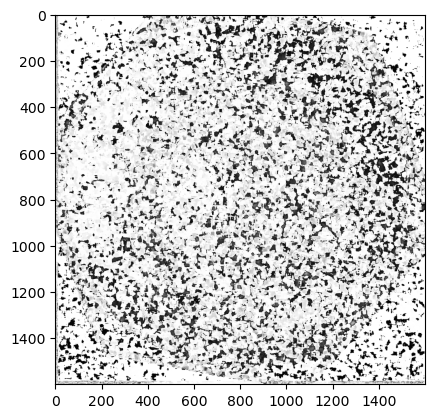

In [81]:
topic = T.ToPILImage()
vimg, vlabels = dataiter.__next__()
plt.imshow(topic(vimg[0]/10))
print(vlabels[0])

In [11]:
class BPNN(nn.Module):
    def __init__(self):
        super(BPNN, self).__init__()
        self.fc1 = nn.Linear(3, 16)  # 输入层到隐藏层
        self.fc2 = nn.Linear(16, 32)  # 隐藏层到隐藏层
        self.fc3 = nn.Linear(32, 1)  # 隐藏层到输出层

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))  # 使用ReLU激活函数的隐藏层
        x = torch.relu(self.fc2(x))  # 使用ReLU激活函数的隐藏层
        x = self.fc3(x)  # 输出层，没有激活函数
        return x

In [43]:
import torch
#import torchvision.transforms as T
import torchvision.transforms.transforms as T
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid())

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y
    
class Bottleneck(nn.Module):
    """
    __init__
        in_channel：残差块输入通道数
        out_channel：残差块输出通道数
        stride：卷积步长
        downsample：在_make_layer函数中赋值，用于控制shortcut图片下采样 H/2 W/2
    """
    expansion = 4   # 残差块第3个卷积层的通道膨胀倍率
    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=1, bias=False)   # H,W不变。C: in_channel -> out_channel
        self.bn1 = nn.BatchNorm2d(num_features=out_channel)
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=stride, bias=False, padding=1)  # H/2，W/2。C不变
        self.bn2 = nn.BatchNorm2d(num_features=out_channel)
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel*self.expansion, kernel_size=1, stride=1, bias=False)   # H,W不变。C: out_channel -> 4*out_channel
        self.bn3 = nn.BatchNorm2d(num_features=out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        # Add SEBlock
        self.seblock = SEBlock(out_channel*self.expansion)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x    # 将原始输入暂存为shortcut的输出
        if self.downsample is not None:
            identity = self.downsample(x)   # 如果需要下采样，那么shortcut后:H/2，W/2。C: out_channel -> 4*out_channel(见ResNet中的downsample实现)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        #Apply SEBlock
        out = self.seblock(out)

        out += identity     # 残差连接0 n
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    """
    __init__
        block: 堆叠的基本模块
        block_num: 基本模块堆叠个数,是一个list,对于resnet50=[3,4,6,3]
        num_classes: 全连接之后的分类特征维度

    _make_layer
        block: 堆叠的基本模块
        channel: 每个stage中堆叠模块的第一个卷积的卷积核个数，对resnet50分别是:64,128,256,512
        block_num: 当期stage堆叠block个数
        stride: 默认卷积步长
    """
    def __init__(self, block, block_num, num_classes, num_attention_heads=4):
        super(ResNet, self).__init__()
        self.in_channel = 64    # conv1的输出维度

        self.conv1 = nn.Conv2d(in_channels=2, out_channels=self.in_channel, kernel_size=7, stride=2, padding=3, bias=False)     # H/2,W/2。C:3->64
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.activation = nn.LeakyReLU(negative_slope=0.01)
        self.sigmoid = nn.Sigmoid()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)     # H/2,W/2。C不变
        self.layer1 = self._make_layer(block=block, channel=64, block_num=block_num[0], stride=1)   # H,W不变。downsample控制的shortcut，out_channel=64x4=256
        self.layer2 = self._make_layer(block=block, channel=128, block_num=block_num[1], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=128x4=512
        self.layer3 = self._make_layer(block=block, channel=256, block_num=block_num[2], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=256x4=1024
        self.layer4 = self._make_layer(block=block, channel=512, block_num=block_num[3], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=512x4=2048

        # 添加自注意力层
        self.self_attention = nn.MultiheadAttention(embed_dim=2048, num_heads=num_attention_heads)

        # Add SEBlocks after each residual block in the feature extraction layers
        self.seblock1 = SEBlock(64 * block.expansion)
        self.seblock2 = SEBlock(128 * block.expansion)
        self.seblock3 = SEBlock(256 * block.expansion)
        self.seblock4 = SEBlock(512 * block.expansion)

        self.fusion4 = MultiScaleFusion(1024 * block.expansion)
        self.fusion3 = MultiScaleFusion(512 * block.expansion)
        self.fusion2 = MultiScaleFusion(256 * block.expansion)
        self.fusion1 = MultiScaleFusion(128 * block.expansion)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))  # 将每张特征图大小->(1,1)，则经过池化后的输出维度=通道数
        self.fc1 = nn.Linear(in_features=512*block.expansion, out_features=1024) #in=2048,out=1024
        self.dropout = nn.Dropout(0.5) #dropout rate
        self.fc2 = nn.Linear(in_features=2048, out_features=1024) #in=1024, out=1
        self.fc3 = nn.Linear(in_features=1024, out_features=num_classes) #in=512, out=1
        #self.fc4 = nn.Linear(in_features=64, out_features=num_classes) #in=128, out=1

        # Upsampling layers for feature fusion
        self.upsample = lambda x: nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=None).to(x.device)
        #self.upsample = nn.functional.interpolate(scale_factor=2, mode='bilinear', align_corners=True)
        
        for m in self.modules():    # 权重初始化
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None   # 用于控制shorcut路的
        if stride != 1 or self.in_channel != channel*block.expansion:   # 对resnet50：conv2中特征图尺寸H,W不需要下采样/2，但是通道数x4，因此shortcut通道数也需要x4。对其余conv3,4,5，既要特征图尺寸H,W/2，又要shortcut维度x4
            downsample = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channel, out_channels=channel*block.expansion, kernel_size=1, stride=stride, bias=False), # out_channels决定输出通道数x4，stride决定特征图尺寸H,W/2
                nn.BatchNorm2d(num_features=channel*block.expansion))

        layers = []  # 每一个convi_x的结构保存在一个layers列表中，i={2,3,4,5}
        layers.append(block(in_channel=self.in_channel, out_channel=channel, downsample=downsample, stride=stride)) # 定义convi_x中的第一个残差块，只有第一个需要设置downsample和stride
        self.in_channel = channel*block.expansion   # 在下一次调用_make_layer函数的时候，self.in_channel已经x4

        for _ in range(1, block_num):  # 通过循环堆叠其余残差块(堆叠了剩余的block_num-1个)
            layers.append(block(in_channel=self.in_channel, out_channel=channel))

        return nn.Sequential(*layers)   # '*'的作用是将list转换为非关键字参数传入

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        #x1 = self.fusion1(x1)
        #x1 = self.seblock1(x1)
        x2 = self.layer2(x1)
        #x2 = self.seblock2(x2)
        #x2 = self.fusion2(x2)
        x3 = self.layer3(x2)
        #x3 = self.seblock3(x3)
        #x3 = self.fusion3(x3)
        x4 = self.layer4(x3)
        #x4 = self.seblock4(x4)
        #x4 = self.fusion4(x4)


        x = self.avgpool(x4)
        x = torch.flatten(x, 1)

        # 添加自注意力层
        #x = x.unsqueeze(0)  # 添加一个维度以适应自注意力层的输入要求
        #x, _ = self.self_attention(x, x, x)
        #x = x.squeeze(0)  # 移除添加的维度
        
        x = self.relu(self.fc1(x))
        #x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

class MultiScaleFusion(nn.Module):
    def __init__(self,out_channels):
        super(MultiScaleFusion, self).__init__()
        self.conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=5, stride=1, padding=2)
        # 定义融合的卷积层
        self.fusion_conv = nn.Conv2d(4*out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        out = torch.cat([x,x1, x2, x3], dim=1)
        # 对融合的特征图进行卷积操作
        out = self.fusion_conv(out)
        out = self.bn(out)
        out = self.relu(out)
        return out

In [13]:
def testAccuracy():
    net.eval()
    accuracy = 0.0
    total = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    x=[]
    y=[]
    np.array(x)
    np.array(y)
    # net=torch.load('')
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader, 0):
            #images, labels = dataiter.next()
            # 输入数据进行预测
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            predata = net(images)
            #predata, labedata = predict(net, valid_loader)
            loss=loss_func(predata, labels)
            loss += loss.item()
            x=np.append(x,[i[0] for i in labels.data.cpu().numpy()])
            y=np.append(y,np.array([i[0] for i in predata.data.cpu().numpy()]))
    preloss = np.mean(loss.data.cpu().numpy()) #preloss = loss/(i+1)
    r2 = 1 - np.mean((y - x) ** 2) / np.mean((x - x.mean()) ** 2)
    vmse = np.mean((y - x) ** 2)
    return(r2,preloss,vmse)

def train(num_epochs,device):
    import time
    start_time = time.process_time()
    best_accuracy = 0.0

    # Define your execution device
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    k=0
    predata=[]
    labeldata=[]
    mseloss=[]
    trainnum=[]
    epochout=[]
    epochV=[]
    vloss=[]
    vr2=[]
    # Convert model parameters and buffers to CPU or Cuda
    net.to(device)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        for i, (images, labels) in enumerate(train_loader, 0):
            #images, labels = dataiter.next()
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            prediction = net(images)
            #print(prediction,labels)
            #print('Prediction data is:',prediction.data.cpu().numpy()[0])
            #print('label data is: ',labels.data.cpu().numpy())
            # 计算预测值与真值误差，注意参数顺序问题
            # 第一个参数为预测值，第二个为真值
            loss = loss_func(prediction, labels)
            # 开始优化步骤
            # 每次开始优化前将梯度置为0
            optimizer.zero_grad()
            # 误差反向传播
            loss.backward()
            # 按照最小loss优化参数
            optimizer.step()
            running_loss += loss.item()

            if (i+1) % 10 == 0:
                # print every 1000 (twice per epoch)
                #print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}")
                print('[Epoch: %d/%d]- %d/%d | loss: %.3f | predict-True: %5d - %5d' %
                      (epoch + 1,num_epochs, i + 1,len(train_loader), loss, prediction.data.cpu().numpy()[0]*226,labels.data.cpu().numpy()[0]*226))
                mseloss.append(running_loss/10)
                trainnum.append(i+1)
                epochout.append(epoch+1)
                result=pd.DataFrame({'epoch':epochout,'trainnum':trainnum,'loss':mseloss})
                result.to_csv("./result/"+casename+"/"+casename+"-result.csv",index=False,sep=',')
                # Tensorboard
                writer.add_scalar('Training loss',running_loss / 10,epoch * len(train_loader) + i)
                # writer.add_figure('predictions vs. actuals',
                # plot_classes_preds(net, inputs, labels),
                # global_step=epoch * len(trainloader) + i)
                # zero the loss
                running_loss = 0.0

            predata.append(prediction.data.cpu().numpy()[0])
            labeldata.append(labels.data.cpu().numpy()[0])

        r2,validloss,vmse = testAccuracy()
        vloss.append(validloss)
        vr2.append(r2)
        epochV.append(epoch+1)
        writer.add_scalar('valid_loss',validloss,epoch+1)
        vresult=pd.DataFrame({'epoch':epochV,'vloss':vloss,'vMSE':vmse,'vr2':vr2})
        vresult.to_csv("./result/"+casename+"/"+casename+"-result-valid.csv",index=False,sep=',')
        print('[Epoch: %d/%d] ======>| Valid Loss: %.3f ,MSE: %.3f | R^2 is %.3f' % (epoch+1,num_epochs,validloss,vmse,r2))
        if validloss <= 0.005:
            k +=1
            print('Validloss K=',k)
            if k == 3 and r2>0.90:
                torch.save(net, casename+'-OK'+'.pt')

            if k == 3 and r2>0.95:
                print('Traing is end, Due to Validloss consecutively less than 0.005.')
                break
        else: k = 0

    print('Finished Training')
    ttime=(np.array(epochout)-1)*len(train_loader)+np.array(trainnum)
    plt.figure()
    plt.legend()
    plt.grid(True)
    plt.ylim(0,0.1)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("train times")
    plt.plot(ttime,mseloss)
    plt.savefig('tranloss.png', dpi=1200) 
    end_time = time.process_time()
    print("Use time:", (end_time-start_time)/3600)


In [44]:
class HuberLossPena(nn.Module):
    def __init__(self, delta=1.0, penalty_weight=1.0):
        super(HuberLossPena, self).__init__()
        self.delta = delta
        self.penalty_weight = penalty_weight

    def forward(self, y_true, y_pred):
        residual = torch.abs(y_true - y_pred)
        condition = residual < self.delta
        squared_loss = 0.5 * residual ** 2
        penalty = self.penalty_weight * (residual - 0.5 * self.delta)
        loss = torch.where(condition, squared_loss, penalty)
        return torch.mean(loss)
    
# 学习率，越大学的越快，但也容易造成不稳定，准确率上下波动的情况
LEARNING_RATE = 0.001

# 定义模型
#net = BPNN()
net = ResNet(block=Bottleneck, block_num=[3,4,36,3],num_classes=1)
casename='caseCG-2'
writer = SummaryWriter("./log/"+casename) #tensorboard

#print(net)
writer.add_graph(net, images)
writer.close()

# 训练网络
# 这里也可以使用其它的优化方法
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE)
# 定义一个误差计算方法
loss_func = HuberLossPena(delta=0.01, penalty_weight=3.0)
#loss_func = nn.MSELoss()
#loss_func = nn.CrossEntropyLoss() #定义交叉熵损失函数 交叉熵损失函数是用来衡量两个概率分布之间的距离的#nn.MSELoss()
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer

In [45]:
print(net)

ResNet(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (seblock): SEBlo

# main 

In [46]:
if __name__ == "__main__":
    
    torch.cuda.empty_cache()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    # Let's build our model
    train(100,device)
    print('Finished Training')
    #Epochごとのlossの保存
    torch.save(net, "./result/"+casename+"/"+casename+".pt")
    # 保存网络中的参数, 速度快，占空间少
    #torch.save(net.state_dict(),'case-1-p.pt')
    #--------------------------------------------------
    #针对上面一般的保存方法，加载的方法分别是：
    # model_dict=torch.load(PATH)
    # model_dict=model.load_state_dict(torch.load(PATH))
    # Test which classes performed well


[Epoch: 1/100]- 10/214 | loss: 3.096 | predict-True:   -71 -   163
[Epoch: 1/100]- 20/214 | loss: 1.301 | predict-True:    82 -   181
[Epoch: 1/100]- 30/214 | loss: 1.588 | predict-True:   121 -     0
[Epoch: 1/100]- 40/214 | loss: 2.208 | predict-True:   239 -    71
[Epoch: 1/100]- 50/214 | loss: 2.920 | predict-True:   283 -    62
[Epoch: 1/100]- 60/214 | loss: 1.652 | predict-True:    24 -   149
[Epoch: 1/100]- 70/214 | loss: 0.186 | predict-True:   141 -   156
[Epoch: 1/100]- 80/214 | loss: 1.037 | predict-True:   138 -    59
[Epoch: 1/100]- 90/214 | loss: 0.790 | predict-True:   130 -    69
[Epoch: 1/100]- 100/214 | loss: 0.209 | predict-True:    51 -    68
[Epoch: 1/100]- 110/214 | loss: 0.472 | predict-True:   125 -   161
[Epoch: 1/100]- 120/214 | loss: 0.538 | predict-True:   120 -    79
[Epoch: 1/100]- 130/214 | loss: 0.190 | predict-True:   117 -   101
[Epoch: 1/100]- 140/214 | loss: 0.021 | predict-True:   114 -   112
[Epoch: 1/100]- 150/214 | loss: 1.163 | predict-True:    

KeyboardInterrupt: 

In [ ]:
print("Displacement:", displacement[1])

Displacement: -6.9825232911103
